In [1]:
import pandas as pd
import numpy as np
import math
import random

from sklearn.metrics import confusion_matrix
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix
from matplotlib import pylab as pl

from sklearn.model_selection import train_test_split


In [47]:
targetAttribute = 'Poisonous/Edible'
targetValue = []
predictedList= []
# maxGainAttr:  spore-print-color    if  maxInfoGain > 0.144354902043, we get the data classified incorrectly
minimalGainThreshold =0.3
defaultTargetValue = 'p'
rawDataSet = 'MushroomDataSet_Before_PreProcessing.xlsx'
processedDataSet = 'MushroomDataSet_After_PreProcessing.xlsx'
columnToProcess = 'stalk-root'
res = {}
rfTargetValue = []
numberOfTrees =100

In [3]:
# data class to hold csv data
def entropy(df):
    # target unique value calculation in form of dictionary
    targetDict = pd.value_counts(df[targetAttribute]).to_dict()
    dfLength = len(df)

    totalEntropy = 0
    # print(targetDict)
    for key, val in targetDict.items():
        multipleVal = val / dfLength
        totalEntropy += multipleVal * math.log2(multipleVal)

    return 0 - totalEntropy


#add values to targetValue
def initializeList(data):
    groupedData = data.groupby([targetAttribute]).groups.keys()
    return groupedData

In [4]:
def calcInforGainForEachAtrribute(df):
    # return maximum info gain
    maxInfoGain = 0;
    infoGainDict = {}
    attributes = list(df)
    totalEntropy = entropy(df)

    for att in attributes:
        # don't calculate gain for target attribute
        if (att == targetAttribute):
            continue
        grouped_data = df.groupby([att], as_index=False)
        totalRows = len(df)
        subEntropy = 0
        # print('keys for ', att, ' total- ', totalRows)

        for key, value in grouped_data:
            eachGroupRows = len(value)
            # print('key-', key, ' eachGroupRows- ', eachGroupRows)

            S = entropy(value)

            # calculate |Sv/S|
            valEntrpy = eachGroupRows / totalRows

            # calculate |Sv/S|*Entropy(Sv)
            subEntropy = subEntropy + valEntrpy * S

        individualEntrpyGain = totalEntropy - subEntropy
        infoGainDict[att] = individualEntrpyGain
        # print('gain-', att, ' - ', individualEntrpyGain)
        if (individualEntrpyGain > maxInfoGain):
            maxInfoGain = individualEntrpyGain
            maxGainAttr = att;

    # If there's no gain at all, nothing has to be done, just return the original set
    if (maxInfoGain < minimalGainThreshold):
        # print("in maxInfoGain")
        # print(maxInfoGain,maxGainAttr)
        print("maxGainAttr: ", maxGainAttr)
        print("maxInfoGain :", maxInfoGain)
        return None, None
    else:
        return maxGainAttr, maxInfoGain


In [5]:
def trueSet(s):
    return len(set(s)) == 1




In [44]:
def createTree(df):
    x = df.drop(labels=targetAttribute, axis=1)
    y = df[targetAttribute]

    # If there could be no split, just return the original set
    if len(y) == 0:
        return y

    if trueSet(y):
        return set(y).pop()

    # We get attribute that gives the highest mutual information

    maxGainAttr, maxInfoGain = calcInforGainForEachAtrribute(df)

    if ((maxGainAttr == None) and (maxInfoGain == None)):
        '''
        df["demo"] = [1]*len(df)
        grouped = df.groupby(targetAttribute)
        x= grouped.count()
        
        max_hi = list(x['demo'])
        index = max_hi.index(max(max_hi))

        indexesVal = x.index.values
        op =indexesVal[index]
        '''
        return defaultTargetValue

    # We split using the selected attribute
    sets = df.groupby(maxGainAttr)
    # print(sets)

    # print(type(sets))
    res = {}
    for k, v in sets:
        res["%s = %s" % (maxGainAttr, k)] = createTree(v)

    return res


In [7]:
def printMatrix(y_test,predictedList,labels):
    cm = confusion_matrix(y_test, pd.Series(predictedList), labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    pl.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

In [8]:
def predictTarget(targetDict,test):
    for k,v in targetDict.items():
        keyList = k.split('=')
        col = keyList[0].strip()
        val = keyList[1].strip()
        if(test[col].iloc[0] == val):
            if k in targetDict:
                temp = targetDict.get(k)
                if(type(temp) == dict):
                    return predictTarget(v,test)
                else:
                    return v

In [9]:
def myPredict1(rfTargetValue, xy_train, xy_test):
    predictedList=[]
    for i in list(range(0,len(xy_train))):
        temp = []
        count = 1
        for tree in rfTargetValue: 
            
            predictedVal = predictTarget(tree,xy_train.iloc[[i]])
            temp.append(predictedVal)
            count = count+1
        
        ######
        #to find majority value
        tempDf= pd.DataFrame(columns= ["target"])
        tempDf["target"] = temp
        tempDf["demo"] = [1]*len(temp)
        grouped = tempDf.groupby("target")
        x= grouped.count()
        
        max_hi = list(x['demo'])
        index = max_hi.index(max(max_hi))

        indexesVal = x.index.values
        op =indexesVal[index]
        #######
        
        predictedList.append(op)
    printMatrix(xy_test ,predictedList,list(targetValue))

In [48]:
datasetAfterProcessing = pd.read_excel('../data/MushroomDataSet_After_PreProcessing.xlsx')
X = datasetAfterProcessing.drop(labels=targetAttribute, axis=1)
y = datasetAfterProcessing[targetAttribute]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
for i in range(numberOfTrees):
    #random_state = random.randint(0,numberOfTrees/2)
    X_train_rf,X_test_rf,Y_train_rf,Y_test_rf = train_test_split(X_train,y_train,test_size = 0.8 ,random_state = i)
    X_train_rf[targetAttribute] = Y_train_rf
    targetValue = initializeList(X_train_rf)
    targetDict = createTree(X_train_rf)
    rfTargetValue.append(targetDict)
    
    
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


maxGainAttr:  spore-print-color
maxInfoGain : 0.157680005061
maxGainAttr:  spore-print-color
maxInfoGain : 0.128300355192
maxGainAttr:  spore-print-color
maxInfoGain : 0.146285906811
maxGainAttr:  spore-print-color
maxInfoGain : 0.166318460809
maxGainAttr:  spore-print-color
maxInfoGain : 0.133709233443
maxGainAttr:  spore-print-color
maxInfoGain : 0.156261518474
maxGainAttr:  spore-print-color
maxInfoGain : 0.137388632338
maxGainAttr:  spore-print-color
maxInfoGain : 0.133779303954
maxGainAttr:  spore-print-color
maxInfoGain : 0.159016579998
maxGainAttr:  spore-print-color
maxInfoGain : 0.142160559853
maxGainAttr:  spore-print-color
maxInfoGain : 0.146688595724
maxGainAttr:  spore-print-color
maxInfoGain : 0.1410416329
maxGainAttr:  spore-print-color
maxInfoGain : 0.146870763247
maxGainAttr:  spore-print-color
maxInfoGain : 0.16205793288
maxGainAttr:  spore-print-color
maxInfoGain : 0.134490539686
maxGainAttr:  spore-print-color
maxInfoGain : 0.12618003571
maxGainAttr:  spore-print-co

In [49]:
rfTargetValue

[{'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor = s': 'p',
  'odor = y': 'p'},
 {'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor = s': 'p',
  'odor = y': 'p'},
 {'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor = s': 'p',
  'odor = y': 'p'},
 {'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor = s': 'p',
  'odor = y': 'p'},
 {'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor = s': 'p',
  'odor = y': 'p'},
 {'odor = a': 'e',
  'odor = c': 'p',
  'odor = f': 'p',
  'odor = l': 'e',
  'odor = m': 'p',
  'odor = n': 'p',
  'odor = p': 'p',
  'odor

[[ 627 2738]
 [   0 3134]]


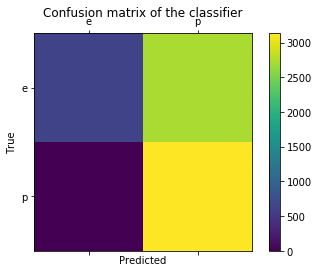

In [50]:
#print(type(X_test))
#print(type(y_test))
#a = X_test.iloc[0]
#b = list(y_test)[0]
myPredict1(rfTargetValue, X_train, y_train)